In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.style.use('seaborn')
sns.set_style('darkgrid')
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)


stocks = prices.columns
returns = prices.pct_change().dropna()
log_prices = np.log(prices)
log_returns = log_prices.diff().dropna()
form_start = '2017-01-05'
form_end = '2020-12-31'
trade_start = '2020-01-01'
trade_end = '2022-12-31'

prices_form = prices.loc[form_start:form_end]
prices_trade = prices.loc[trade_start:trade_end]
log_prices_form = log_prices.loc[form_start:form_end]
log_prices_trade = log_prices.loc[trade_start:trade_end]
log_returns_form = log_returns.loc[form_start:form_end]
log_returns_trade = log_returns.loc[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

<ipython-input-7-5e926f461342>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
res = coint_johansen(log_prices[[stocks[0], stocks[1], stocks[2], stocks[3]]], det_order=0, k_ar_diff=1)

In [9]:
res.lr2


array([862.87798522, 459.04220623, 372.71282849,  40.13696935])

In [10]:
res.cvm


array([[25.1236, 27.5858, 32.7172],
       [18.8928, 21.1314, 25.865 ],
       [12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [11]:
res.cvm[:,-1]


array([32.7172, 25.865 , 18.52  ,  6.6349])

In [12]:
res.lr2 > res.cvm[:,-2]


array([ True,  True,  True,  True])

In [13]:
from itertools import combinations

combs = []

# save all possible quadruplets
for c in combinations(stocks, 4):
    combs.append(c)

# convert to dataframe
combs = np.array(combs)
combs = pd.DataFrame(combs, columns=['s1','s2','s3','s4'])
len(combs)

4845

In [14]:
index = list(combs.index)

num_pfs = 1 # number of portfolios to select
selected_quad = []
selected_stocks = []

while len(selected_quad)<num_pfs and len(index)>0:
    i = random.choice(index) # choose random quadruplet
    s1,s2,s3,s4 = combs.loc[i] # parse stocks in quadruplet
    index.remove(i) # remove processed row

    try:
        res = coint_johansen(log_prices[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    except:
        continue

    if sum(res.lr2 > res.cvm[:,-2]) == 4: # if null is rejected at 95% level
        print(f'{s1}-{s2}-{s3}-{s4}')
        selected_quad.append([s1,s2,s3,s4])
        selected_stocks.extend([s1,s2,s3,s4])

        # remove all quadruplets containing already selected stocks
        for s in [s1,s2,s3,s4]:
            for c in combs.columns:
                combs = combs.loc[~(combs[c]==s)]
                index = list(set(index).intersection(set(combs.index)))

        #print(f'{len(index)} items left')

Instr4-Instr6-Instr10-Instr16


In [15]:
selected_quad


[['Instr4', 'Instr6', 'Instr10', 'Instr16']]

In [17]:
s1,s2,s3,s4 = ['Instr4', 'Instr6', 'Instr10', 'Instr16']
res = coint_johansen(log_prices[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
res.lr2 > res.cvm[:,-2]

array([ True,  True,  True,  True])

In [18]:
res.eig

array([0.29484125, 0.26830775, 0.12934563, 0.0158003 ])

In [19]:
res.evec


array([[ 3.50700001, -2.39576551, -1.14803174, -0.41063661],
       [-1.34528217,  5.56196898, -0.83733809, -0.03954822],
       [-4.84592263, -5.17308102, -0.2213416 , -0.22468844],
       [ 2.49258118,  1.85797965,  2.34544836, -0.35232313]])

In [20]:
res.evec[:,0]


array([ 3.50700001, -1.34528217, -4.84592263,  2.49258118])

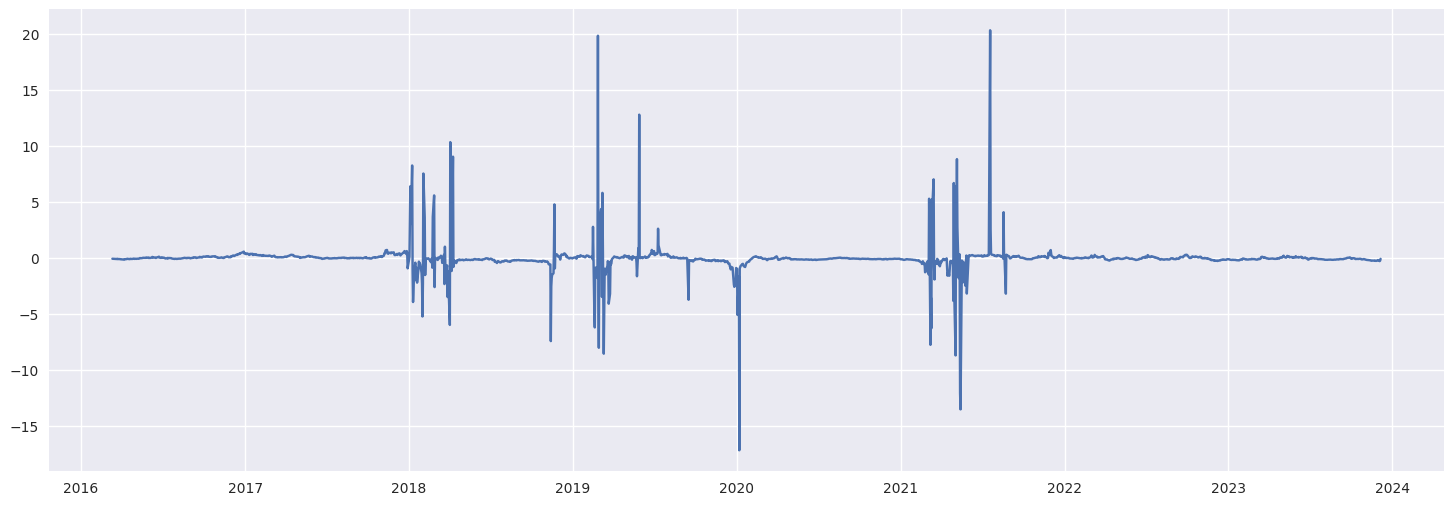

In [21]:
# create cointegrated portfolio
pf = (res.evec[:,0] * log_prices[[s1,s2,s3,s4]]).sum(axis=1)
plt.figure(figsize=(18,6))
plt.plot(pf)

In [22]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(pf)


(-13.734236763823878,
 1.125185125891669e-25,
 7,
 1992,
 {'1%': -3.4336370214482437,
  '5%': -2.862992025899885,
  '10%': -2.5675429970585153},
 6656.268264510395)

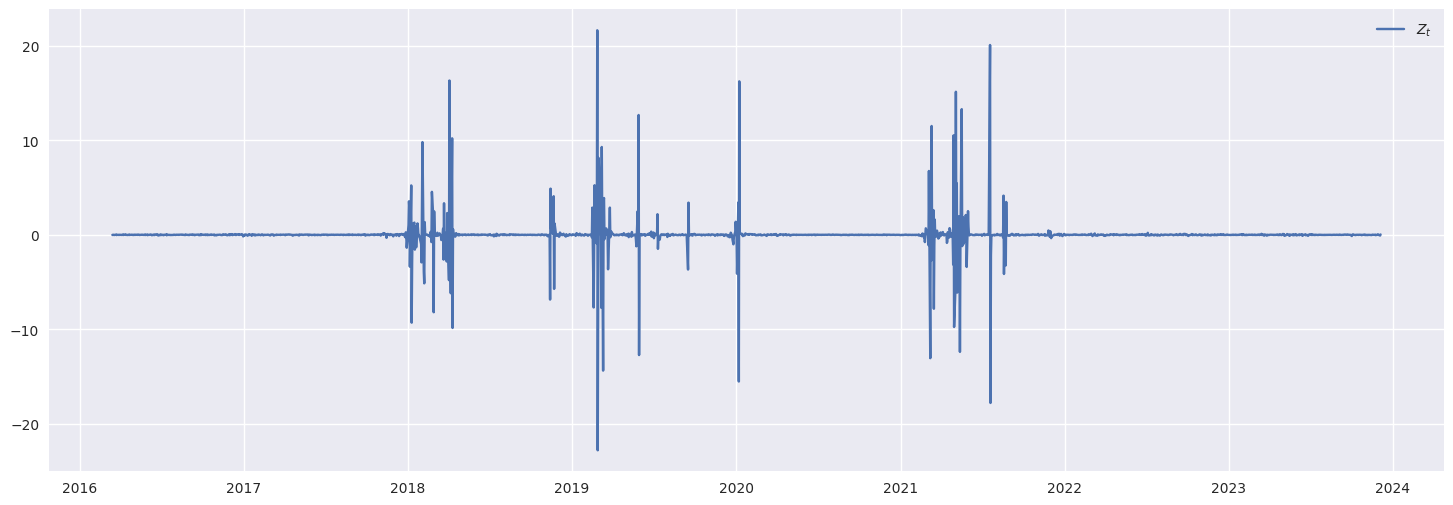

In [23]:
b = res.evec[:,0]
Z = (b * log_returns[[s1,s2,s3,s4]]).sum(axis=1)

plt.figure(figsize=(18,6))
plt.plot(Z, label=r'$Z_t$')
plt.legend()

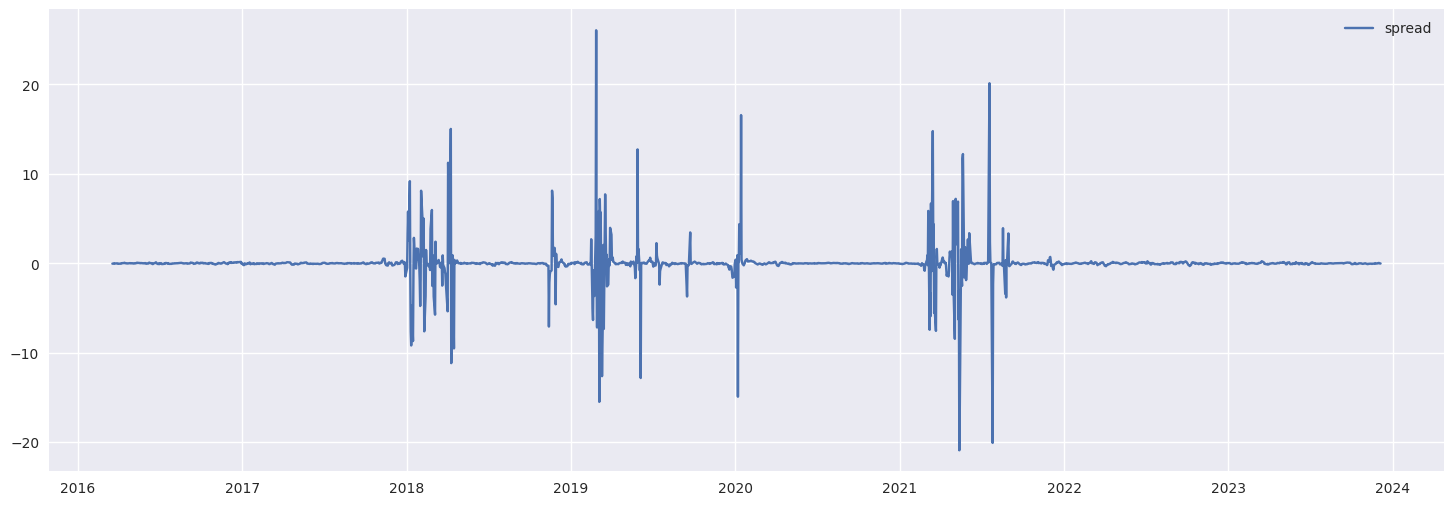

In [24]:
P = 5 # max lag parameter
spread = Z.rolling(P).sum()

plt.figure(figsize=(18,6))
plt.plot(spread, label='spread')
plt.legend()


In [25]:
weights = res.evec[:,0]
weights[weights>0] /= sum(weights[weights>0])
weights[weights<0] /= sum(abs(weights[weights<0]))
weights

array([ 0.5845408 , -0.21728924, -0.78271076,  0.4154592 ])

In [26]:
spread = spread.dropna()
positions = pd.DataFrame(index=spread.index, columns=[s1,s2,s3,s4])
positions[spread>0] = -weights # short position
positions[spread<0] = weights # long position

In [27]:
ret_is = (positions.shift() * returns[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
cumret_is = np.nancumprod(ret_is+1)
# cumulative returns of each stock
cumret_all = (prices.pct_change().dropna() + 1).cumprod(axis=0)
# cumulative returns of buy and hold strategy
cumret_bnh = (1/4 * cumret_all[[s1,s2,s3,s4]]).sum(axis=1)
# simple returns of buy and hold strategy
ret_bnh = cumret_bnh.pct_change().dropna()


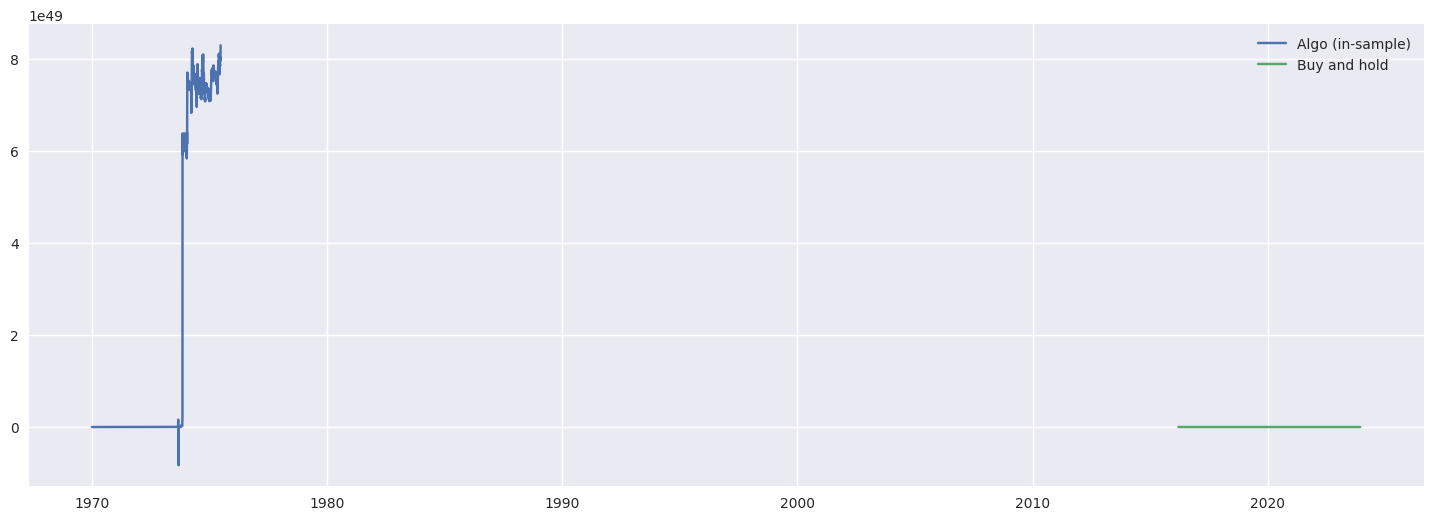

In [28]:
plt.figure(figsize=(18,6))
plt.plot(cumret_is, label='Algo (in-sample)')
plt.plot(cumret_bnh, label='Buy and hold')
plt.legend()


In [29]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)

    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)

    return total_return, apr, sharpe, maxDD, maxDDD

In [30]:
def shuffle_positions(positions_df):

    positions = positions_df.copy().values

    # shuffle positions within each column
    for col in range(positions.shape[1]):
        split =  np.split(positions[:,col], np.where((np.diff(positions[:,col]) != 0))[0]+1)
        pos = [x for x in split if x[0]!=0] # all non-zero positions
        pos_length = sum([len(x) for x in pos]) # total length in days
        zero_length = len(positions[:,col]) - pos_length
        pos += np.split(np.array([0]*zero_length), np.arange(1,zero_length))
        random.shuffle(pos)
        pos = np.concatenate(pos).astype(int)
        positions[:,col] = pos
    # shuffle columns
    np.random.shuffle(np.transpose(positions))

    shuffled_df = pd.DataFrame(positions, index=positions_df.index, columns=positions_df.columns)

    return shuffled_df

In [31]:
bootstrap_trs = [] # total returns
N = 5000 # number of random tests

for _ in range(N):
    positions_bootstrap = shuffle_positions(positions)
    ret = (positions_bootstrap.shift() * returns[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
    cumret_bootstrap = np.nancumprod(ret+1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return

bootstrap_trs = np.array(bootstrap_trs)

Streaming output truncated to the last 5000 lines.
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-input-29-8ed914f6bee2>:8: RuntimeWarning: invalid value encountered in double_scalars
  sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
<ipython-inpu

In [32]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe',
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s1])
pct_beaten = 'NA'
results_df.loc[s1] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s2])
results_df.loc[s2] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s3])
results_df.loc[s3] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s4])
results_df.loc[s4] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_bnh)
results_df.loc['Buy and hold'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_is)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (in-sample)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

In [33]:
results_df

,Total return,APR,Sharpe,maxDD,maxDDD,% random portfolios beaten
Instr4,-6.293068e-01,-1.175935e-01,0.642175,-9.998151e-01,1013.0,NA
Instr6,-5.905219e-01,-1.064546e-01,0.396933,-9.999381e-01,1013.0,NA
Instr10,-5.302399e-01,-9.084964e-02,0.859025,-9.995910e-01,1013.0,NA
Instr16,-4.254132e-01,-6.746821e-02,0.461707,-9.999804e-01,1013.0,NA
Buy and hold,-5.435007e-01,-9.412559e-02,1.135971,-9.948817e-01,1013.0,NA
Algo (in-sample),8.297111e+49,1.963049e+06,0.824571,-5.620673e+14,523.0,100.0


In [34]:
def calculate_metrics_add(ret):
    '''
    calculate performance metrics from returns
    '''
    best_day = np.max(ret)
    worst_day = np.min(ret)
    pct_days_up = len(ret[ret>0]) / len(ret)
    pct_days_down = len(ret[ret<0]) / len(ret)
    avg_daily_gain = np.mean(ret[ret>0])
    sd_pos_ret = np.std(ret[ret>0])
    avg_daily_loss = np.mean(ret[ret<0])
    sd_neg_ret = np.std(ret[ret<0])

    return best_day, worst_day, pct_days_up, pct_days_down, avg_daily_gain, sd_pos_ret, avg_daily_loss, sd_neg_ret
metrics = ['Best day', 'Worst day', 'Percentage of up days', 'Percentage of down days',
           'Average daily gain', 'SD of positive returns', 'Average daily loss',
           'SD of negative returns']

results_add_df = pd.DataFrame(index=metrics, columns=['Algo (in-sample)', 'Buy and hold', s1,s2,s3,s4])
results_add_df['Algo (in-sample)'] = calculate_metrics_add(ret_is)
results_add_df['Buy and hold'] = calculate_metrics_add(ret_bnh)
results_add_df[s1] = calculate_metrics_add(returns[s1])
results_add_df[s2] = calculate_metrics_add(returns[s2])
results_add_df[s3] = calculate_metrics_add(returns[s3])
results_add_df[s4] = calculate_metrics_add(returns[s4])


In [35]:
results_add_df


,Algo (in-sample),Buy and hold,Instr4,Instr6,Instr10,Instr16
Best day,643.992773,16.589652,369.803732,1406.099688,75.399381,574.074074
Worst day,-11.746082,-0.934820,-0.996780,-0.997418,-0.996979,-0.999325
Percentage of up days,0.526263,0.503003,0.500750,0.503252,0.501251,0.494747
Percentage of down days,0.470235,0.496496,0.494747,0.492246,0.491246,0.500250
Average daily gain,2.147715,0.165312,0.866746,1.672158,0.324351,0.866614
SD of positive returns,29.014136,0.604752,13.092690,44.325212,2.821985,18.313310
Average daily loss,-0.075539,-0.101456,-0.118737,-0.111978,-0.109295,-0.107730
SD of negative returns,0.586776,0.127716,0.164600,0.156442,0.149040,0.153549


In [36]:
corr_df = pd.DataFrame(index=[s1,s2,s3,s4], columns=['Algo (in-sample)'])

for s in corr_df.index:
    corr_df.loc[s] = np.corrcoef(returns[s], ret_is)[0,1]

corr_df

,Algo (in-sample)
Instr4,0.52549
Instr6,0.684341
Instr10,0.387995
Instr16,0.514106


In [37]:
returns[[s1,s2,s3,s4]].corr()


,Instr4,Instr6,Instr10,Instr16
Instr4,1.000000,0.028360,0.021937,0.001114
Instr6,0.028360,1.000000,0.372047,0.014676
Instr10,0.021937,0.372047,1.000000,0.025935
Instr16,0.001114,0.014676,0.025935,1.000000


In [38]:
combs = []

# save all possible quadruplets
for c in combinations(stocks, 4):
    combs.append(c)

# convert to dataframe
combs = np.array(combs)
combs = pd.DataFrame(combs, columns=['s1','s2','s3','s4'])

In [39]:
ndex = list(combs.index)

num_pfs = 1 # number of portfolios to select
selected_quad = []
selected_stocks = []

while len(selected_quad)<num_pfs and len(index)>0:
    i = random.choice(index) # choose random quadruplet
    s1,s2,s3,s4 = combs.loc[i] # parse stocks in quadruplet
    index.remove(i) # remove processed row

    try:
        res = coint_johansen(log_prices_form[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    except:
        continue

    if sum(res.lr2 > res.cvm[:,-2]) == 4: # if null is rejected at 95% level
        print(f'{s1}-{s2}-{s3}-{s4}')
        selected_quad.append([s1,s2,s3,s4])
        selected_stocks.extend([s1,s2,s3,s4])

        # remove all quadruplets containing already selected stocks
        for s in [s1,s2,s3,s4]:
            for c in combs.columns:
                combs = combs.loc[~(combs[c]==s)]
                index = list(set(index).intersection(set(combs.index)))

        print(f'{len(index)} items left')

Instr2-Instr5-Instr8-Instr11
495 items left


In [40]:
s1,s2,s3,s4 = 'Instr2','Instr5','Instr8','Instr11'

In [41]:
W = 504 # window size
P = 5 # max lag parameter

positions_oos = pd.DataFrame(index=returns_trade.index, columns=[s1,s2,s3,s4])

for t in log_prices_trade.index:
    # prepare data
    log_prices_tmp = log_prices.loc[:t]
    log_prices_tmp = log_prices_tmp.iloc[-W:]
    log_returns_tmp = log_returns.loc[:t]
    log_returns_tmp = log_returns_tmp.iloc[-W:]

    # estimate cointegration vector
    res = coint_johansen(log_prices_tmp[[s1,s2,s3,s4]], det_order=0, k_ar_diff=1)
    max_eval = res.ind[0] # maximum eigenvalue index
    b = res.evec[:,max_eval] # cointegration vector

    # calculate spread
    Z = (b * log_returns_tmp[[s1,s2,s3,s4]]).sum(axis=1)
    spread = Z.rolling(P).sum()

    # calculate weights
    weights = res.evec[:,max_eval]
    weights[weights>0] /= sum(weights[weights>0])
    weights[weights<0] /= sum(abs(weights[weights<0]))

    if spread.iloc[-1] > 0:
        positions_oos.loc[t] = -weights
    else:
        positions_oos.loc[t] = weights
ret_oos = (positions_oos.shift() * returns_trade[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
cumret_oos = np.nancumprod(ret_oos+1)

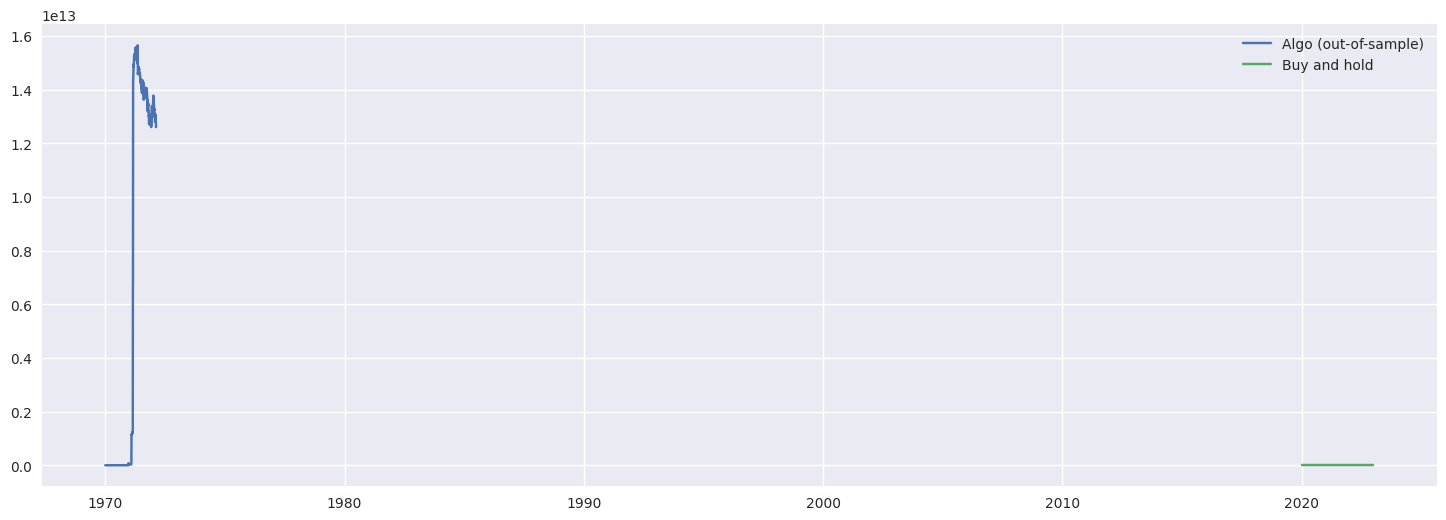

In [43]:
# cumulative returns of each stock
cumret_all = (prices_trade.pct_change().dropna() + 1).cumprod(axis=0)
# cumulative returns of buy and hold strategy
cumret_bnh = (1/4 * cumret_all[[s1,s2,s3,s4]]).sum(axis=1)
# simple returns of buy and hold strategy
ret_bnh = cumret_bnh.pct_change().dropna()
plt.figure(figsize=(18,6))
plt.plot(cumret_oos, label='Algo (out-of-sample)')
plt.plot(cumret_bnh, label='Buy and hold')
plt.legend()


In [44]:
bootstrap_trs = [] # total returns
N = 5000 # number of random tests

for _ in range(N):
    positions_bootstrap = shuffle_positions(positions_oos)
    ret = (positions_bootstrap.shift() * returns_trade[[s1,s2,s3,s4]]).sum(axis=1) * 2 # double the amount of capital
    cumret_bootstrap = np.nancumprod(ret+1)
    bootstrap_trs.append(calculate_metrics(cumret_bootstrap)[0]) # save total return

bootstrap_trs = np.array(bootstrap_trs)
# cumulative returns of each stock
cumret_all = (prices_trade.pct_change().dropna() + 1).cumprod(axis=0)

results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe',
                                   'maxDD', 'maxDDD', '% random portfolios beaten'])
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s1])
pct_beaten = 'NA'
results_df.loc[s1] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s2])
results_df.loc[s2] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s3])
results_df.loc[s3] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_all[s4])
results_df.loc[s4] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten
total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_bnh)
results_df.loc['Buy and hold'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten

total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret_oos)
pct_beaten = 100 * (1 - len(bootstrap_trs[bootstrap_trs>total_return]) / len(bootstrap_trs))
results_df.loc['Algo (out-of-sample)'] = total_return, apr, sharpe, maxDD, maxDDD, pct_beaten


Streaming output truncated to the last 5000 lines.
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars
  apr = (1+total_return)**(252/len(cumret)) - 1
<ipython-input-29-8ed914f6bee2>:16: RuntimeWarning: divide by zero encountered in double_scalars
  drawdown[t]=cumret[t]/highwatermark[t]-1
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars
  apr = (1+total_return)**(252/len(cumret)) - 1
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars
  apr = (1+total_return)**(252/len(cumret)) - 1
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars
  apr = (1+total_return)**(252/len(cumret)) - 1
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars
  apr = (1+total_return)**(252/len(cumret)) - 1
<ipython-input-29-8ed914f6bee2>:6: RuntimeWarning: invalid value encountered in double_scalars

In [ ]:
results_df


In [ ]:
metrics = ['Best day', 'Worst day', 'Percentage of up days', 'Percentage of down days',
           'Average daily gain', 'SD of positive returns', 'Average daily loss',
           'SD of negative returns']

results_add_df = pd.DataFrame(index=metrics, columns=['Algo (out-of-sample)','Buy and hold',s1,s2,s3,s4])

results_add_df['Algo (out-of-sample)'] = calculate_metrics_add(ret_oos)
results_add_df['Buy and hold'] = calculate_metrics_add(ret_bnh)
results_add_df[s1] = calculate_metrics_add(returns_trade[s1])
results_add_df[s2] = calculate_metrics_add(returns_trade[s2])
results_add_df[s3] = calculate_metrics_add(returns_trade[s3])
results_add_df[s4] = calculate_metrics_add(returns_trade[s4])


In [ ]:
results_add_df


In [ ]:
corr_df = pd.DataFrame(index=[s1,s2,s3,s4], columns=['Algo (out-of-sample)'])

for s in corr_df.index:
    corr_df.loc[s] = np.corrcoef(returns_trade[s], ret_oos)[0,1]

corr_df

In [ ]:
returns_trade[[s1,s2,s3,s4]].corr()
